In [2]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import pandas as pd
from bs4 import BeautifulSoup
import requests
from newspaper import Article

In [3]:
# For Topic Modeling
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models import FastText

import numpy as np
import os
from random import shuffle
import re
import matplotlib.pyplot as plt 
import numpy as np
import pyLDAvis
import pyLDAvis.gensim

In [4]:
# Loading our two pipelines
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

config = {"punct_chars": [".", "?", "!", "。"]}
nlp.add_pipe('sentencizer')

In [5]:
# Using panda to load in our .csv file
df = pd.read_csv("urls.csv") # File we are checking
urls = df["Address"].tolist() # Column name we are checking
url_sent_score = []
url_sent_label = []
url_subj_score = []
url_subj_label = []
total_pos = []
total_neg = []
topic_sentiment = []

In [6]:
def get_named_entities(doc):
    ent_list = []
    for ent in doc.ents:
        ent_list.append((ent.text,ent.label_))
    return ent_list

def get_sentences(doc):
    return doc.sents

def get_sentence_list(doc):
    return [sent for sent in doc.sents]

#Takes a doc object from spacy and returns a tuple list of form (sentence, sentiment of sentence) for all sentences
def sentence_sentiment_from_doc(doc):
    sentences = get_sentences(doc)
    tuple_list = []
    for sentence in sentences:
        sent_doc = nlp(sentence.text)
        tuple_list.append((sentence.text,sent_doc._.blob.polarity))
    return tuple_list

#Finds all named entities (does not filter by person, date, etc) and returns sentiment value based on the sentences they
#are included in. Returns dictionary of form {entity name : sentiment value}
def sentence_sentiment_on_named_entities(doc):
    named_ent_list = get_named_entities(doc)
    sentence_sentiment_list = sentence_sentiment_from_doc(doc)
    return_dict = {}
    
    for (name, label) in named_ent_list:
        #print(name, "\n")
        #print(type(name))
        return_dict[name] = 0
        
        for (sentence, sentiment) in sentence_sentiment_list:
             if sentence.find(name) != -1:
                    #print(name,sentence)
                    return_dict[name] += sentiment
    
    return return_dict

#takes in a single topic word, the word's weight, and the doc, and returns sentiment of that word within the doc
def sentence_level_sentiment_of_word(word, weight, doc):
    sentence_sentiment_list = sentence_sentiment_from_doc(doc)
    sentiment_total = 0
    
    for (sentence, sentiment) in sentence_sentiment_list:
             if sentence.find(word) != -1:
                    #print(name,sentence)
                    sentiment_total += sentiment
    return sentiment_total

def weighted_word_sentiment(word,weight, doc):
    sentiment = sentence_level_sentiment_of_word(word, weight, doc)
    weighted_sentiment = sentiment * weight
    return weighted_sentiment

In [7]:
def get_doc(url):
    article = Article(url)
    article.download()
    article.parse()

    page_text = (article.text).lower()
    page_text = page_text.strip().replace("  ","")
    page_text = "".join([s for s in page_text.splitlines(True) if s.strip("\r\n")])
    
    # Start the sentiment analysis now
    doc = nlp(page_text)
    return doc


In [8]:
#https://pypi.org/project/spacytextblob/
for count, x in enumerate(urls):
    if(count % 10 == 0):
        print(count)
    try:
        url = x
        
        
#         headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36'}
#         res = requests.get(url,headers=headers)
#         html_page = res.text

#         soup = BeautifulSoup(html_page, 'html.parser')
#         for script in soup(["script", "style","meta","label","header","footer"]):
#             script.decompose()
#         page_text = (soup.get_text()).lower()
#         page_text = page_text.strip().replace("  ","")
#         page_text = "".join([s for s in page_text.splitlines(True) if s.strip("\r\n")])
        
        doc = get_doc(url)
        sentiment = doc._.blob.polarity
        sentiment = round(sentiment,2)
        subjectivity = doc._.blob.subjectivity
        subjectivity = round(subjectivity,2)
        
#         if count / 3 == 1:
#             print("enter test spot\n")
#             #ent_list = get_named_entities(doc)
#             #print(ent_list)
#             sentence_sentiment_list = sentence_sentiment_from_doc(doc)
#             #sent_1 = sentence_sentiment_list.pop()
#             #print(sent_1)
#             #print(type(sent_1[0]))
#             print(sentence_sentiment_list)
#             topic_level_sentiment = sentence_sentiment_on_named_entities(doc)
#             #print(topic_level_sentiment)
#             print(sentence_level_sentiment_of_word('kansas',0,doc))
#             break
            
        #print("\n")

        # Gives positive or negative label
        if sentiment >= -0.033 and sentiment <= 0.043:
            sent_label = "Neutral"
        elif sentiment > 0.043 and sentiment < 0.143:
            sent_label = "Neutral Positive"
        elif sentiment > 0.143:
            sent_label = "Positive"
        elif sentiment < -0.033 and sentiment > -0.062:
            sent_label = "Neutral Negative"
        elif sentiment < -0.062:
            sent_label = "Negative"

        #Document's topic-level sentiment assessment of named entities
        topic_level_sentiment = sentence_sentiment_on_named_entities(doc)
        topic_sentiment.append(topic_level_sentiment)
        
        #Adding label, sentiment, subjectivity of document
        url_sent_label.append(sent_label)
        url_sent_score.append(sentiment)
        url_subj_score.append(subjectivity)

        positive_words = []
        negative_words = []

        for x in doc._.blob.sentiment_assessments.assessments:
          if x[1] > 0:
            positive_words.append(x[0][0])
          elif x[1] < 0:
            negative_words.append(x[0][0])
          else:
            pass

        total_pos.append(', '.join(set(positive_words)))
        total_neg.append(', '.join(set(negative_words)))
    except:
        url_sent_label.append("Error")
        url_sent_score.append(0.0)
        url_subj_score.append(0.0)
        topic_sentiment.append({'Error':0})

        positive_words = []
        negative_words = []

        total_pos.append(', '.join(set(positive_words)))
        total_neg.append(', '.join(set(negative_words)))

print("The average sentiment score was: " + str(sum(url_sent_score) / len(url_sent_score)))
print("The average subjectivity score was: " + str(sum(url_subj_score) / len(url_subj_score)))

df["Sentiment Score"] = url_sent_score
df["Sentiment Label"] = url_sent_label
df["Subjectivity Score"] = url_subj_score
df["Positive Words"] = total_pos
df["Negative Words"] = total_neg
df["Topic Sentiment"] = topic_sentiment

df

0
10


c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


20


c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


30


c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


40
50
60


c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


70


c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


80


c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


90
100
110


c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


120
The average sentiment score was: 0.01692307692307693
The average subjectivity score was: 0.25238461538461543


,Address,Sentiment Score,Sentiment Label,Subjectivity Score,Positive Words,Negative Words,Topic Sentiment
0,https://www.thegatewaypundit.com/2022/05/world...,0.05,Neutral Positive,0.28,"supporting, free, effectively, new, confident,...","absolutely, single, past, other, needless","{'this week': 0.1325, 'davos': 0.1325, 'switze..."
1,https://gettr.com/post/ptt4ta7c84,0.00,Neutral,0.00,,,{}
2,https://komonews.com/news/coronavirus/if-covid...,-0.03,Neutral,0.37,,military,"{'brady mcneil': -0.03333333333333333, 'the ve..."
3,https://www.lewrockwell.com/2018/11/no_author/...,0.10,Neutral Positive,0.41,"available, able, best, aptly, new, newly, majo...","unknown, poor, military, other, difficult, typ...","{'spanish': 0.6340909090909091, 'an estimated ..."
4,https://nation.com.pk/08-Apr-2021/russia-offer...,0.07,Neutral Positive,0.28,"economic, natural, good, particularly, early, ...","mainly, foreign, actively, military","{'islamabad': 0.03452380952380952, 'russia': 1..."
...,...,...,...,...,...,...,...
125,https://youtu.be/9jMONZMuS2U,0.00,Neutral,0.00,,,{}
126,https://www.militaryreligiousfreedom.org/2022/...,0.03,Neutral,0.44,"best, new, direct, predictably, large, clear, ...","wrong, cynical, troubled, military, no, danger...","{'the 1990s': 0.125, 'dod': -0.037976190476190..."
127,https://www.scribd.com/document/575750142/ECF-...,0.07,Neutral Positive,0.00,useful,not,"{'100%': 0.07499999999999998, '0%': 0.07499999..."
128,https://www.theepochtimes.com/investigative-re...,-0.05,Neutral Negative,0.36,,military,{'u.s.': -0.1}


In [9]:
# store as list of lists of words
def preprocess_article(doc):
    x = get_sentence_list(doc)
    input_text = [str(sentence) for sentence in x]

    # Set a minimum word length threshold
    min_word_length = 3

    sentences_ted = []
    for sent_str in input_text:
        tokens = re.sub(r"[^a-z]+", " ", sent_str.lower()).split()
        tokens = [token for token in tokens if not token.isdigit()]
        tokens = [token for token in tokens if len(token) >= min_word_length]
        sentences_ted.append(tokens)

    stoplist = []
    with open('stopwords') as openfileobject:
        for line in openfileobject:
            stoplist.append(line[:-1])
    stoplist = set(stoplist)

    for i in range(len(sentences_ted)):
        for word in reversed(sentences_ted[i]):
            if word in stoplist:
                sentences_ted[i].remove(word)
    return sentences_ted

In [10]:
preprocessed_articles = [
    
]
x = 0
for count, url in enumerate(urls):
    try:
        x += 1
        text = get_doc(url)
        preprocessed_articles.append(preprocess_article(text))
    except:
        pass

all_text = []
for corpus in preprocessed_articles:
    for word in corpus:
        all_text.append(word)
dictionary = Dictionary(all_text)
dictionary.filter_extremes(no_below=0.1, no_above=0.9)
bow_corpora = []

for corpus in preprocessed_articles:
    bow_corpus = ([dictionary.doc2bow(sentence) for sentence in corpus])
    for bow in bow_corpus:
        bow_corpora.append(bow)
print(x)

c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion o

130


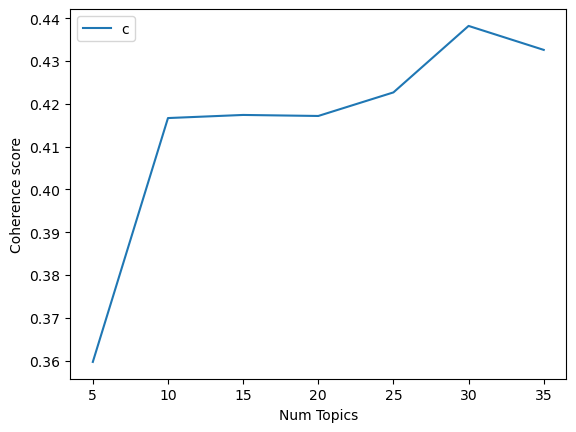

In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        #model = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics = num_topics, id2word=dictionary,random_state=100,passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpora, texts=all_text, start=5, limit=40, step=5)
# Show graph
limit=40; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score 
of {coherence_values[best_result_index]}''')

The 30 topics gives the highest coherence score 
of 0.4381903966813953


In [1]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(optimal_model, bow_corpora, dictionary)
p

NameError: name 'pyLDAvis' is not defined

In [14]:
for topic_id, topic_words in model_topics:
    print("Topic: " + str(topic_id))
    weighted_topic_sentiment = 0
    word_sentiment_list = []
    for word, weight in topic_words:
        word_sentiment_list.append(weighted_word_sentiment(word, weight, doc))
    for sentiment in word_sentiment_list:
        weighted_topic_sentiment += sentiment
    weighted_topic_sentiment /= len(word_sentiment_list) /100
    print("Topic Words: " + str(topic_words))
    print("Sentiment = " + str(weighted_topic_sentiment))

Topic: 20
Topic Words: [('vaccine', 0.047762007), ('military', 0.030306043), ('covid', 0.029877981), ('religious', 0.028903427), ('know', 0.027283365), ('members', 0.026752314), ('exemptions', 0.02621115), ('vaccines', 0.024862403), ('many', 0.018052047), ('service', 0.013682678)]
Sentiment = 0.027078070677816864
Topic: 27
Topic Words: [('story', 0.016922388), ('look', 0.015619418), ('hours', 0.015352002), ('full', 0.013229774), ('put', 0.01149944), ('street', 0.0108544575), ('took', 0.010747948), ('course', 0.010671954), ('vaccine', 0.010613927), ('using', 0.010510897)]
Sentiment = 0.13576135941019113
Topic: 17
Topic Words: [('experienced', 0.019355657), ('symptoms', 0.01777509), ('way', 0.01577205), ('category', 0.015546614), ('vaccine', 0.014002294), ('summary', 0.013708051), ('ensure', 0.013649327), ('signs', 0.013111018), ('however', 0.01292093), ('codes', 0.012731578)]
Sentiment = 0.0
Topic: 7
Topic Words: [('national', 0.031152815), ('medical', 0.022390729), ('guard', 0.02071133

In [15]:
error_count = 0
f = open("topic_data.txt", "w")
for count, url in enumerate(urls):
    try:
        doc = get_doc(url)  # Load the document
        article = preprocess_article(doc)  # Preprocess and convert to bag-of-words
        bow_doc = ([dictionary.doc2bow(sentence) for sentence in article])
        topic_distribution = optimal_model.get_document_topics(bow_doc)  # Get the topic distribution
        for topic in topic_distribution[0]:
            topic_words = optimal_model.show_topic(topic[0])
            f.write(str(topic_words))
            f.write("\n")
        f.write(str(url))
        f.write("\n")
        f.write(str(doc))
        f.write("\n\n\n")
    except:
        error_count +=1

print("errors: ", error_count)

c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\anaconda3\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion o

errors:  35


In [ ]:
for count, url in enumerate(urls):
    try:
        doc = get_doc(url)  # Load the document
        article = preprocess_article(doc)  # Preprocess and convert to bag-of-words
        bow_doc = ([dictionary.doc2bow(sentence) for sentence in article])
        topic_distribution = optimal_model.get_document_topics(bow_doc)  # Get the topic distribution
        for topic in topic_distribution:
            topic_words = optimal_model.show_topic(topic[0])
        print(topic_words)
        print(doc)
        print("\n\n\n")
    except:
        pass

[('ability', 0.019844556), ('percent', 0.018846802), ('everyone', 0.018234974), ('way', 0.017806841), ('added', 0.016909074), ('nothing', 0.015575855), ('increase', 0.014609384), ('among', 0.0145179825), ('court', 0.01414686), ('would', 0.014135173)]





[('ability', 0.019844556), ('percent', 0.018846802), ('everyone', 0.018234974), ('way', 0.017806841), ('added', 0.016909074), ('nothing', 0.015575855), ('increase', 0.014609384), ('among', 0.0145179825), ('court', 0.01414686), ('would', 0.014135173)]





[('ability', 0.019844556), ('percent', 0.018846802), ('everyone', 0.018234974), ('way', 0.017806841), ('added', 0.016909074), ('nothing', 0.015575855), ('increase', 0.014609384), ('among', 0.0145179825), ('court', 0.01414686), ('would', 0.014135173)]





[('ability', 0.019844556), ('percent', 0.018846802), ('everyone', 0.018234974), ('way', 0.017806841), ('added', 0.016909074), ('nothing', 0.015575855), ('increase', 0.014609384), ('among', 0.0145179825), ('court', 0.01414686), ('wou